In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize

from data.input_data import time_opticaldensity_ph_glucose_protein

In [47]:
temperature_data = pd.DataFrame({
    "t, °C": [
        35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0,
        37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0,
        40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0,
        45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0
    ],
    "Time": [
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0,
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0,
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0,
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0
    ],
    "OpticalDensity": [
        0.086266, 0.224488, 0.646507, 0.930303, 0.952850, 1.025000, 1.002845,
        0.090474, 0.235439, 0.678044, 0.975684, 0.999331, 1.075000, 1.051765,
        0.087108, 0.226678, 0.652814, 0.939379, 0.962146, 1.035000, 1.012629,
        0.073642, 0.191636, 0.551896, 0.794161, 0.813409, 0.875000, 0.856087
    ]
})

In [48]:
def temp_multiplier(temp: float, sigma: float, floor: float, T_opt: float = 37.0) -> float:
    """
    Normalized temperature multiplier:
    - Equals 1.0 at optimal temperature T_opt
    - Approaches `floor` far from T_opt (0 < floor < 1)
    - `sigma` controls the width of the optimal range
    """
    return floor + (1.0 - floor) * np.exp(-((temp - T_opt) ** 2) / (2.0 * sigma ** 2))


# Use only the final OD at each temperature (e.g., ~24h) and fit ratios vs 37°C
final_od_by_temp = (
    temperature_data.sort_values('Time')
    .groupby('t, °C')['OpticalDensity']
    .apply(lambda s: s.iloc[-1])
)
od_37 = final_od_by_temp.loc[37.0]
od_ratio = final_od_by_temp / od_37


# Fit sigma and floor with bounds to keep them in a sensible range; fix T_opt = 37°C
# p0: sigma ~ 3°C, floor ~ 0.6
def temp_multiplier_fixed_Topt(temp, sigma, floor):
    return temp_multiplier(temp, sigma, floor, T_opt=37.0)


p0 = [3.0, 0.6]
bounds = ([0.1, 0.1], [20.0, 0.99])
(m_sigma, m_floor), _ = curve_fit(
    temp_multiplier_fixed_Topt,
    od_ratio.index.values.astype(float),
    od_ratio.values.astype(float),
    p0=p0,
    bounds=bounds,
)

print(f"Temperature multiplier fitted (T_opt fixed at 37°C): sigma={m_sigma:.3f}, floor={m_floor:.3f}")

Temperature multiplier fitted (T_opt fixed at 37°C): sigma=4.236, floor=0.777


In [54]:
def simulate_with_temperature(
    params: np.ndarray, temperature: float = 37.0
) -> tuple[np.ndarray, ...]:
    """
    DBN-like simulation with a normalized temperature multiplier.
    Base parameters are calibrated at 37°C, so temperature only scales
    growth / consumption / production rates, not the baseline offsets.
    """
    Xs, pHs, Gs, Bs = (
        [time_opticaldensity_ph_glucose_protein['OpticalDensity'].iloc[0]],
        [time_opticaldensity_ph_glucose_protein['pH'].iloc[0]],
        [time_opticaldensity_ph_glucose_protein['Glucose'].iloc[0]],
        [time_opticaldensity_ph_glucose_protein['Protein'].iloc[0]]
    )
    timestamps = len(time_opticaldensity_ph_glucose_protein) - 1

    # Normalized multiplier (1 at 37°C)
    m = temp_multiplier(temperature, m_sigma, m_floor, T_opt=37.0)

    for _ in range(timestamps):
        X, pH, G, B = Xs[-1], pHs[-1], Gs[-1], Bs[-1]
        # Only scale the dynamic (rate-like) parts by m; leave offsets unscaled
        X_lin = params[0] * X + params[1] * pH + params[2] * G + params[3] * B
        X_next = X_lin * m

        pH_next = params[4] + params[5] * pH - params[6] * X  # pH dynamics not temperature-scaled by default
        G_next = G - params[7] * X * m
        B_next = B + params[8] * X * m - params[9] * B

        Xs.append(X_next)
        pHs.append(pH_next)
        Gs.append(G_next)
        Bs.append(B_next)
    return np.array(Xs), np.array(pHs), np.array(Gs), np.array(Bs)


def loss_with_temperature(params: np.ndarray) -> float:
    total_error = 0.0

    # Base error at 37°C (the dataset time_opticaldensity_ph_glucose_protein was collected near optimal temperature)
    X_pred, pH_pred, G_pred, B_pred = simulate_with_temperature(params)
    base_error = (
        np.sum((X_pred - time_opticaldensity_ph_glucose_protein['OpticalDensity'].values) ** 2) +
        np.sum((pH_pred - time_opticaldensity_ph_glucose_protein['pH'].values) ** 2) +
        np.sum((G_pred - time_opticaldensity_ph_glucose_protein['Glucose'].values) ** 2) +
        np.sum((B_pred - time_opticaldensity_ph_glucose_protein['Protein'].values) ** 2)
    )
    total_error += base_error

    # Temperature-specific error using only X trajectory vs temperature_data
    for temp in temperature_data['t, °C'].unique():
        temp_subset = temperature_data[temperature_data['t, °C'] == temp]
        X_temp_pred, _, _, _ = simulate_with_temperature(params, float(temp))
        temp_error = np.sum(
            (X_temp_pred - temp_subset['OpticalDensity'].values) ** 2
        )
        total_error += temp_error
    return total_error

In [55]:
params = np.array([0.6, 0.3, 0.05, 0.02, 0.01, 0.01, 0.01, 0.3, 0.8, 0.4])

print('Оптимізація параметрів базової динаміки при 37°C з урахуванням нормалізованої температури')
res = minimize(loss_with_temperature, params, method='L-BFGS-B', options={'maxiter': 50000})
print('Оптимальні параметри:', res.x)
print('Фінальна помилка:', res.fun)

Оптимізація параметрів базової динаміки при 37°C з урахуванням нормалізованої температури
Оптимальні параметри: [-0.32666333  0.2423282  -0.03047695  0.02182904  2.70990513  0.52443382
  1.20817073  4.42066661 -1.52856876 -0.0973133 ]
Фінальна помилка: 8.542165648014905
Оптимальні параметри: [-0.32666333  0.2423282  -0.03047695  0.02182904  2.70990513  0.52443382
  1.20817073  4.42066661 -1.52856876 -0.0973133 ]
Фінальна помилка: 8.542165648014905


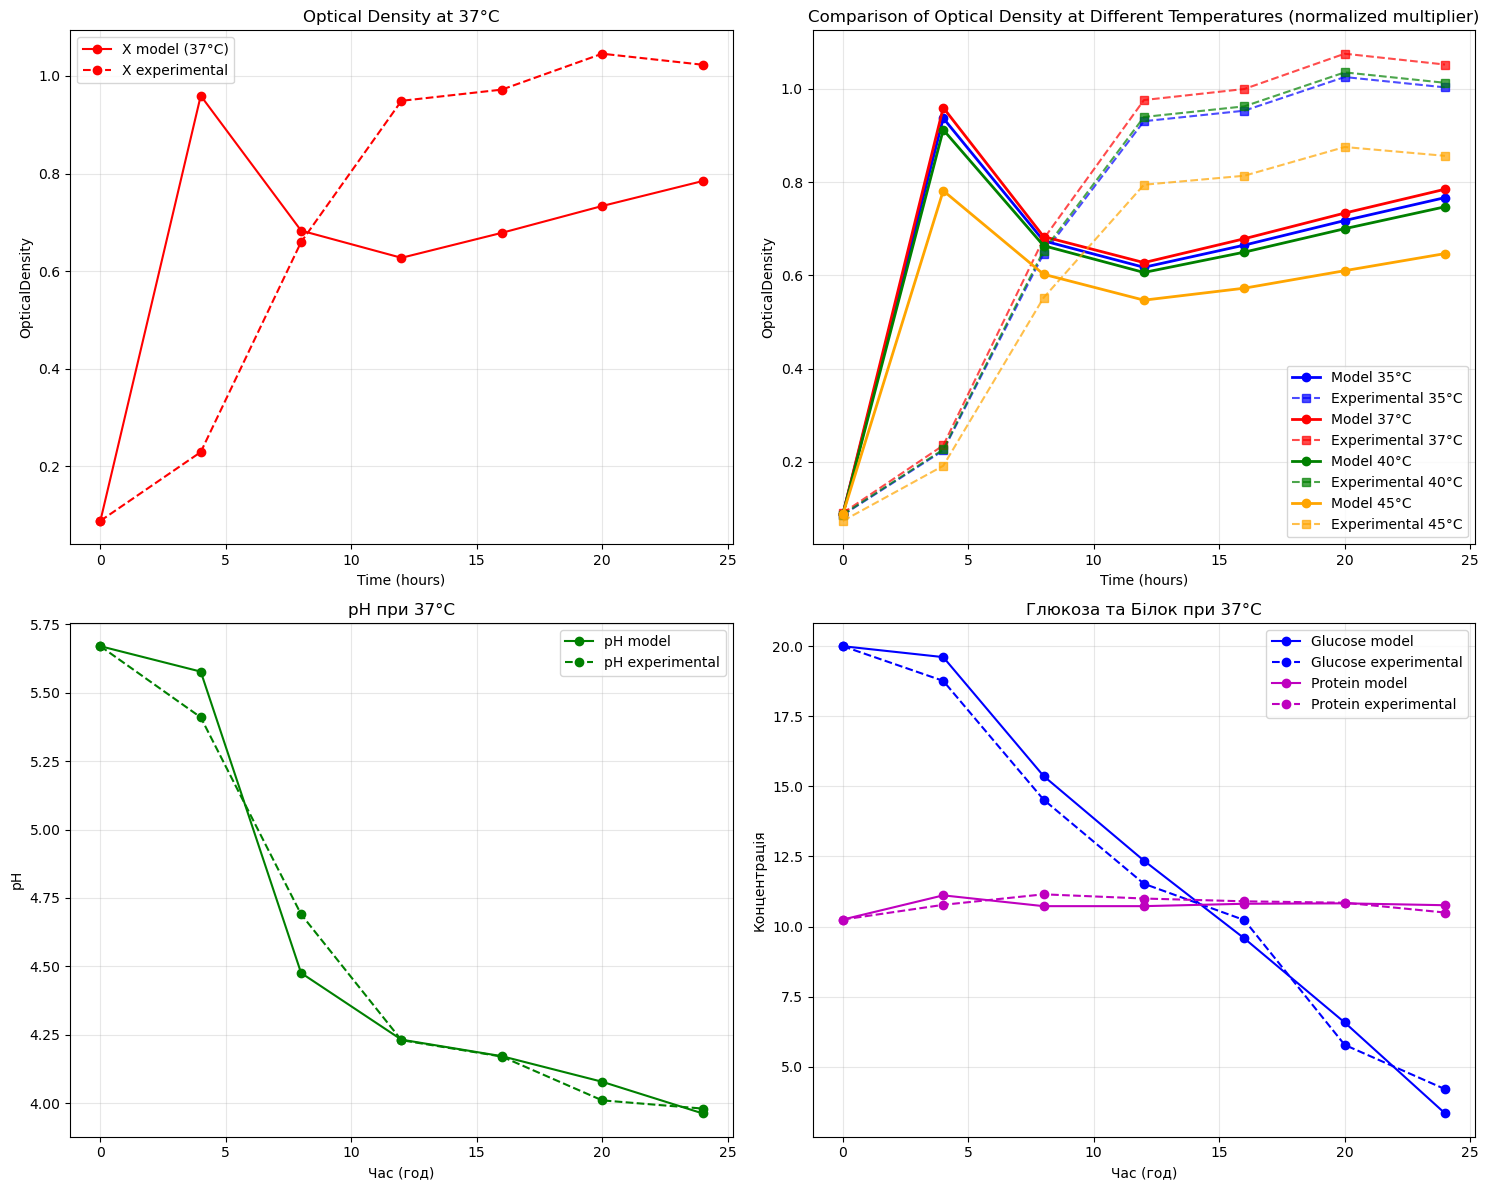

In [57]:
# Plot

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Use optimized params if available, otherwise fall back to initial params
plot_params = res.x if 'res' in locals() and hasattr(res, 'x') else params

# Convenience time array
times = time_opticaldensity_ph_glucose_protein['Time']

# Base model (37°C)
X_model, pH_model, G_model, B_model = simulate_with_temperature(plot_params, 37.0)

axes[0, 0].plot(times, X_model, 'r-', label='X model (37°C)', marker='o')
axes[0, 0].plot(times, time_opticaldensity_ph_glucose_protein['OpticalDensity'], 'ro--', label='X experimental')
axes[0, 0].set_title('Optical Density at 37°C')
axes[0, 0].set_xlabel('Time (hours)')
axes[0, 0].set_ylabel('OpticalDensity')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Comparison of temperature
colors = ['blue', 'red', 'green', 'orange']
for i, temp in enumerate([35, 37, 40, 45]):
    X_temp, _, _, _ = simulate_with_temperature(plot_params, temp)
    temp_subset = temperature_data[temperature_data['t, °C'] == temp]

    axes[0, 1].plot(
        times, X_temp, color=colors[i], label=f'Model {temp}°C', marker='o', linewidth=2
    )
    axes[0, 1].plot(
        temp_subset['Time'], temp_subset['OpticalDensity'], color=colors[i], linestyle='--', marker='s',
        label=f'Experimental {temp}°C', alpha=0.7,
    )

axes[0, 1].set_title('Comparison of Optical Density at Different Temperatures (normalized multiplier)')
axes[0, 1].set_xlabel('Time (hours)')
axes[0, 1].set_ylabel('OpticalDensity')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# pH та Глюкоза при 37°C
axes[1,0].plot(times, pH_model, 'g-', label='pH model', marker='o')
axes[1,0].plot(times, time_opticaldensity_ph_glucose_protein['pH'], 'go--', label='pH experimental')
axes[1,0].set_title('pH при 37°C')
axes[1,0].set_xlabel('Час (год)')
axes[1,0].set_ylabel('pH')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(times, G_model, 'b-', label='Glucose model', marker='o')
axes[1,1].plot(times, time_opticaldensity_ph_glucose_protein['Glucose'], 'bo--', label='Glucose experimental')
axes[1,1].plot(times, B_model, 'm-', label='Protein model', marker='o')
axes[1,1].plot(times, time_opticaldensity_ph_glucose_protein['Protein'], 'mo--', label='Protein experimental')
axes[1,1].set_title('Глюкоза та Білок при 37°C')
axes[1,1].set_xlabel('Час (год)')
axes[1,1].set_ylabel('Концентрація')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== АНАЛІЗ ТЕМПЕРАТУРНОГО ЕФЕКТУ (нормалізований) ===


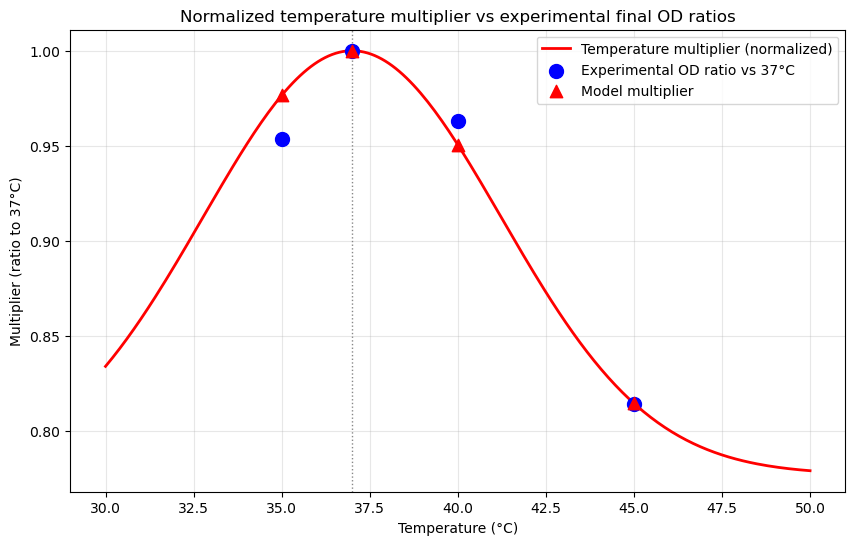

T_opt fixed: 37.0°C | sigma=4.236, floor=0.777
Predicted final OD at temperatures:
	35°C -> final OD = 0.767 (ratio=0.977)
	37°C -> final OD = 0.785 (ratio=1.000)
	40°C -> final OD = 0.747 (ratio=0.952)
	45°C -> final OD = 0.647 (ratio=0.824)


In [59]:
print('=== АНАЛІЗ ТЕМПЕРАТУРНОГО ЕФЕКТУ (нормалізований) ===')

temp_range = np.linspace(30, 50, 200)
mult_vals = [temp_multiplier(t, m_sigma, m_floor, 37.0) for t in temp_range]

plt.figure(figsize=(10, 6))
plt.plot(temp_range, mult_vals, 'r-', linewidth=2, label='Temperature multiplier (normalized)')

# Scatter experimental final OD ratios and model predictions
plt.scatter(
    od_ratio.index.values, od_ratio.values, color='blue', s=100, label='Experimental OD ratio vs 37°C', zorder=5
)

for temp in [35, 37, 40, 45]:
    X_pred, _, _, _ = simulate_with_temperature(res.x, temp)
    final_od_ratio = X_pred[-1] / X_model[-1] if temp != 37 else 1.0
    plt.scatter(
        temp,
        temp_multiplier(temp, m_sigma, m_floor, 37.0),
        color='red',
        s=80,
        marker='^',
        label='Model multiplier' if temp == 35 else "",
        zorder=6
    )

plt.axvline(37, color='#888', linestyle=':', linewidth=1)
plt.xlabel('Temperature (°C)')
plt.ylabel('Multiplier (ratio to 37°C)')
plt.title('Normalized temperature multiplier vs experimental final OD ratios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f'T_opt fixed: 37.0°C | sigma={m_sigma:.3f}, floor={m_floor:.3f}')
print('Predicted final OD at temperatures:')
for temp in [35, 37, 40, 45]:
    X_pred, _, _, _ = simulate_with_temperature(res.x, temp)
    print(
        f'\t{temp}°C -> final OD = {X_pred[-1]:.3f} (ratio={X_pred[-1]/simulate_with_temperature(res.x, 37.0)[0][-1]:.3f})'
    )